### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (100 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $2000$ bootstrap realizations of this dataset. Using an appropriate timing function in python, how long did the generation of these realizations take? 
*DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together. This code will be graded on efficiency and speed; it should not take more than 1 second to execute.*

5) Repeat (2) with all $2000$ boostrap datasets to find the distribution of the sample mean. How long did this take? Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $2000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

Installing numdifftools here to start:

In [158]:
!pip install numdifftools

### <font color='green'>**PART ONE!**</font>

1) Read in `hw3_data_1.npy`. This is a (100 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

In [159]:
import numpy as np # Very convenient!

data = np.load("hw3_data_1.npy") # Loading the dataset

measurements = data[:, 0]  # First column is measurements
uncertainties = data[:, 1]  # Second column is uncertainties

The heteroscedastic mean takes the form:

$$\hat{\mu} = \frac{\sum_i^N(\frac{x_i}{\sigma_i^2})}{\sum_i^N(\frac{1}{\sigma_i^2})}$$

So, we compute it like this:


In [160]:
weights = 1 / (uncertainties ** 2) # Weights to apply to these things

hetero_mean = np.sum(weights * measurements) / np.sum(weights) # Weighted heteroscedastic mean

print("The heteroscedastic weighted mean is:", hetero_mean)

The heteroscedastic weighted mean is: 4.082099776157916


The heteroscedastic standard error takes the form:

$$\sigma_{\hat{\mu}}=\left[\sum_i^N\left(\frac{1}{\sigma_i^2}\right)\right]^{-\frac{1}{2}}$$

Now, we compute it like this:

In [161]:
hetero_standard_error = (np.sum(weights)) ** (-1/2) # Heteroscedastic standard error

print("The heteroscedastic standard error is:", hetero_standard_error)

The heteroscedastic standard error is: 0.0937975025520293


### <font color='green'>**PART TWO!**</font>
2) Reusing some approaches and tools from `Lecture_5`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

In [162]:
# Nice things to import
import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
import matplotlib.pyplot as plt

Here, we construct the log likelihood function from lecture, construct the same lambda function, and then compute the maximum likelihood with an initial guess of 2.5.

In [163]:
# Redefining data usefully:
x = np.linspace(0, 5, 100)
y = measurements
dy = uncertainties

# Defining the standard squared-loss function.
def log_likelihood(mu, x, dx):
    return np.sum(((x - mu) / (2 * dx)) ** 2 - (1 / np.sqrt(2 * np.pi * dx))) 
    # Note the constant/main term comes from applying ln to the product

# Defining a lambda function that defines the sum of squared errors. 
f_squared = lambda beta: log_likelihood(beta[0], x=measurements, dx=uncertainties)

# Computing the maximum likelihood 
beta0 = (2.5) # Why not? A good and silly guess :))) 
beta_squared = optimize.fmin(f_squared, beta0)

# Final answer:
print("The MLE for the Gaussian distribution is:", beta_squared)

Optimization terminated successfully.
         Current function value: -8.845706
         Iterations: 17
         Function evaluations: 34
The MLE for the Gaussian distribution is: [4.08209229]


Thus, our MLE of the Gaussian's mean is 4.08209229.

### <font color='green'>**PART THREE!**</font>
3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

Different from the original heteroscedastic standard error, we stick the log likelihood into the Hessian function from the numdifftools and compute the Fisher matrix error by applying the following operation: 

$$\sigma_{\mu} = \left( - \frac{\partial^2\ln L(\mu)}{\partial\mu^2}\Biggr\rvert_{\hat \mu}\right)^{-1/2}$$


In [164]:
# More shit that we need (numdifftools)
import numdifftools as nd

# Defining the inverse log likelihood (negative sign lol)
def inv_log_likelihood(mu, x, dx):
    return -np.sum(((x - mu) / (2 * dx)) ** 2)

# Computing the Fisher matrix error!
H = nd.Hessian(inv_log_likelihood)(beta_squared, measurements, uncertainties)
sigmaHet = (-H[0][0])**(-0.5)

# The print out in question
print("The Fisher matrix error is:", sigmaHet)

The Fisher matrix error is: 0.13264970022580472


SRT: Fair enough. I would've expected numdifftools to get closer to the analytic estimate. However, this is also not the method referred to in Lecture 5, which was a finite difference estimate of the second derivative on  a grid of parameter values. -1 point

### <font color='green'>**PART FOUR!**</font>
4) Using the bootstrap method, generate $2000$ bootstrap realizations of this dataset. Using an appropriate timing function in python, how long did the generation of these realizations take? 
*DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together. This code will be graded on efficiency and speed; it should not take more than 1 second to execute.*

Here, I randomly select integers from 0 to n (100 for this dataset) and stick them into an array of size n times the number of samples taken (2000). We then use that array on the data to pull out all the bootstrap realizations of the data:

In [165]:
# Useful imports
import numpy as np
import time

# Creation of the bootstrap function
def bootstrap(data, num_samples):
    start_time = time.perf_counter() # Start time
    n = len(data)  # Number of data points (100)
    indices = np.random.randint(0, n, size=(num_samples, n)) # num_samples (2000) by n (100) array of indices
    bootstrap_samples = data[indices] # Using indices to select bootstrap samples
    elapsed_time = time.perf_counter() - start_time # Final time
    return bootstrap_samples, elapsed_time

# Generate 2000 bootstrap samples
bootstrap_samples, time_passed = bootstrap(data, 2000)

# Check the shape: It should be (2000, 100, 2)
print("It took", time_passed, "seconds to generate the bootstrap samples.")
print("Bootstrap samples shape:", bootstrap_samples.shape)

It took 0.004905374997179024 seconds to generate the bootstrap samples.
Bootstrap samples shape: (2000, 100, 2)


### <font color='green'>**PART FIVE!**</font>

5) Repeat (2) with all $2000$ boostrap datasets to find the distribution of the sample mean. How long did this take? Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?


The time it took to find the distributio of the sample mean is (in seconds): 0.6411551250057528


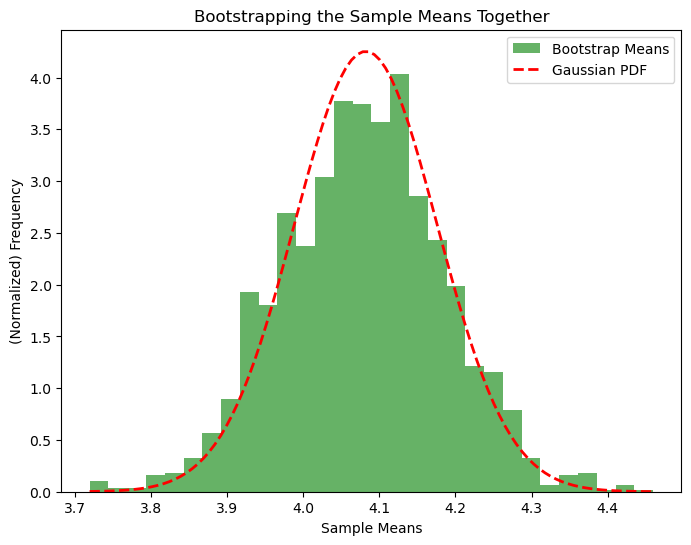

In [166]:
# Running Part 2 on each bootstrap in the sample:

start_time = time.perf_counter() # Start time
bootstrapped_means = [] # Defining the list of bootstrapped means

# Collecting all the means!
for sample in bootstrap_samples: 
    x = sample[:, 0]  # First column is measurements
    dx = sample[:, 1]  # Second column is uncertainties
    bootstrap_lnlikelihood = lambda beta: log_likelihood(beta[0], x, dx) # Doing the log likelihood here
    beta0 = x[0]
    beta_squared = optimize.fmin(bootstrap_lnlikelihood, beta0, disp=False) # Optimization
    bootstrapped_means.append(beta_squared[0])

elapsed_time = time.perf_counter() - start_time # The elapsed time
print("The time it took to find the distributio of the sample mean is (in seconds):", elapsed_time)

bootstrapped_means_array = np.array(bootstrapped_means) # I am so sorry at how gross this is please forgive me

# Plotting the damn thing!!
plt.figure(figsize=(8, 6))
count, bins, _ = plt.hist(bootstrapped_means_array, bins=30, density=True, alpha=0.6, color='green', label="Bootstrap Means")
x = np.linspace(bins[0], bins[-1], 100)
pdf = norm.pdf(x, loc=hetero_mean, scale=hetero_standard_error)
plt.plot(x, pdf, 'r--', linewidth=2, label="Gaussian PDF")

# Some clarifying labels
plt.xlabel("Sample Means")
plt.ylabel("(Normalized) Frequency")
plt.title("Bootstrapping the Sample Means Together")
plt.legend()
plt.show()


SRT: Excellent!

### <font color='green'>**PART SIX!**</font>

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

To construct the Laplacian log likelihood function, we can move through a similar process depicted for Gaussians and Poisson distributions, where we stick the distribution into the log likelihood repeated multiplication, and then apply a logarithm.

The Laplacian distribution takes the form:

$$p(x_i|\mu,\Delta)=\frac{1}{2\Delta}e^{-\frac{|x-\mu|}{\Delta}}$$

Where $\mu$ is the location parameter and $\delta$ is the scale parameter. The likelihood will be:

$$L \equiv p(\{x_i\}|\mu,\Delta) = \prod_{i=1}^{N} \frac{1}{2\Delta}e^{-\frac{|x-\mu|}{\Delta}}$$

Now, we take the log to get the log likelihood:

$$ln L \equiv p(\{x_i\}|\mu,\Delta) = N\ln(1)-\sum_{i=1}^N\left[\frac{|x-\mu|}{\Delta}-\ln(2\Delta)\right]$$

In [167]:
# Importing laplace function
from scipy.stats import laplace

# Redefining data usefully:
x = measurements
dx = uncertainties

# Defining the standard squared-loss function for the Laplacian.
def laplace_log_likelihood(mu, x, dx):
    return -1 * np.sum(laplace.logpdf(x, loc=mu, scale=dx))

# Defining a lambda function that defines the sum of squared errors. 
f_lnlaplace = lambda beta: laplace_log_likelihood(mu=beta[0], x=measurements, dx=beta[1])

# Computing the maximum likelihood 
beta0 = (3, 0.1) # Why not? A good and silly guess :)))
beta_laplace = optimize.fmin(f_lnlaplace, beta0)

# Final answer:
print("The MLE for the Laplacian distribution is (mean, uncertainty):", beta_laplace)

Optimization terminated successfully.
         Current function value: 161.631942
         Iterations: 52
         Function evaluations: 96
The MLE for the Laplacian distribution is (mean, uncertainty): [4.08983788 0.92604872]


### <font color='green'>**PART SEVEN!**</font>
7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

From the lectures, the **Akaike Information Criterion** (AIC) is depicted as so:

$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

where $k$ is the number of model parameters and $N$ is the number of data points. The first term is the ln-likelohood multiplied by -2, and the others are described by k meaning parameters and N meaning total data points (helped from https://www.sciencedirect.com/topics/pharmacology-toxicology-and-pharmaceutical-science/akaike-information-criterion#:~:text=Akaike's%20Information%20Criterion%20(AIC)%20can,the%20number%20of%20model%20estimated)

Below, we can calculate the AIC values for both models as so:

In [171]:
# For both:
N_value = 100 # Length of the data

# For the Gaussian:
log_likelihood_gaussian = beta_squared[0] # Picking up from the Gaussian MLE from above
k_value_gaussian = 1 # Location and scale parameters

# For the Laplacian:
log_likelihood_laplacian = beta_laplace[0] # Picking up from the Laplacian MLE from above
k_value_laplacian = 2 # Location and scale parameters

# AIC function
def AIC(log_likelihood, k, N):
    return (2 * k) - (2 * log_likelihood) + ((2 * k * (k + 1)) / (N - k - 1))

# Final answers:
print("The AIC for the Gaussian distribution is:", AIC(log_likelihood_gaussian, k_value_gaussian, N_value), "while the AIC for the Laplacian distribution is:", AIC(log_likelihood_laplacian, k_value_laplacian, N_value))

The AIC for the Gaussian distribution is: -6.462517067083221 while the AIC for the Laplacian distribution is: -4.055964424593821


SRT: Correct answer, but you forgot that the output of the optimization function is the negative log likelihood. So you need to negative it again to get back the actual log likelihood. -2 points

Thus, this means that the AIC proves the Gaussian distribution fits the data better!

### <font color='green'>**PART EIGHT!**</font>

8) Using the $2000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

(2000, 2)


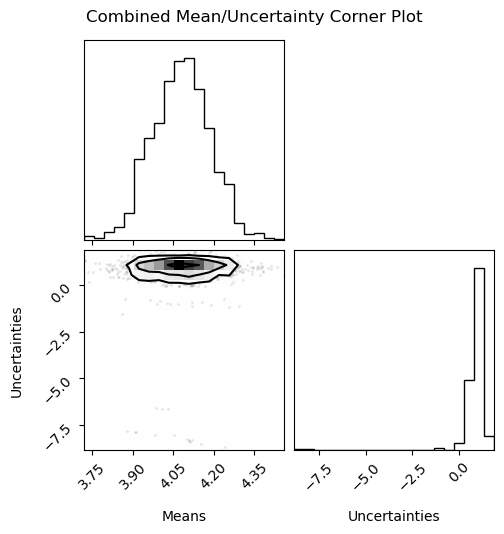

In [169]:
# A VERY useful import
import corner

bootstrapped_laplacian_means = [] # Defining the list of bootstrapped laplacian means
bootstrapped_laplacian_uncertainties = [] # Defining the list of bootstrapped laplacian uncertainties

# Collecting all the means and uncertainties!
for sample in bootstrap_samples: 
    x = sample[:, 0]  # First column is measurements
    dx = sample[:, 1]  # Second column is uncertainties
    bootstrap_laplace_lnlikelihood = lambda beta: laplace_log_likelihood(beta[0], x, dx) # Doing the laplacianlog likelihood here
    beta0 = (x[0], dx[0]) # TWO guesses to spit out TWO values
    beta_squared = optimize.fmin(bootstrap_lnlikelihood, beta0, disp=False) # Optimization
    bootstrapped_laplacian_means.append(beta_squared[0]) 
    bootstrapped_laplacian_uncertainties.append(beta_squared[1])

# A bunch of data management (don't look it's ugly)
bootstrapped_laplacian_means_array = np.array(bootstrapped_laplacian_means) # Doing this again
bootstrapped_laplacian_uncertainties_array = np.array(bootstrapped_laplacian_uncertainties) # Lmao
bootstrapped_laplacian_data = np.vstack((bootstrapped_laplacian_means_array, bootstrapped_laplacian_uncertainties_array)) # For ease of corner plotting
bootstrapped_final_data = bootstrapped_laplacian_data.transpose() # Going from the wrong to the right shape
print(bootstrapped_final_data.shape)

# Plotting the damn thing!!
figure = corner.corner(bootstrapped_final_data, labels=["Means", "Uncertainties"])
plt.title("Combined Mean/Uncertainty Corner Plot", x=-0.2, y=2.1)
plt.show()

SRT: Titles on each 1D marginal panel? Correct parameter labels, ie.., mu and delta? -2 points

### <font color='green'>**PART NINE!**</font>
9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [170]:
# Defining the inverse log likelihood (negative sign lol)
def inv_log_likelihood_laplace(mu, x, dx):
    return np.sum(laplace.logpdf(x, loc=mu, scale=dx))

# Computing the Fisher matrix error!
H = nd.Hessian(inv_log_likelihood_laplace)(log_likelihood_laplacian, measurements, uncertainties)
sigmaHetLaplace = (-H[0][0])**(-0.5)

# The print out in question
print("The Fisher matrix error is:", sigmaHetLaplace)

The Fisher matrix error is: 0.1168162045737626


SRT: No, you needed to put in the best-fit mu and delta values from above, not assume that the delta was equal to the data uncertainties. You should get two uncertainties from this calculation, one for each Laplacian parameter. -3 points

The Fisher matrix error for the Laplacian actually fit the blob on the central corner plot quite closely! Incredibly promising :)

# <font color='green'>**END!**</font>